# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
###Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  

This is the Writeup / README file.

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called `some_file.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import pickle
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from pathlib import Path
%matplotlib inline

from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [63]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)    
    
# Define a function to extract features from a list of images

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)                
        else: feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() to get color histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    return features

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [146]:
def train_SVC_if_needed():
    dist_pickle = Path("./svc_pickle.p")
    if dist_pickle.is_file():
        return

    # Divide up into cars and notcars
    images = glob.glob('HOG_Full_Size/*/*/*')
    cars = []
    notcars = []
    for image in images:
        if 'non-vehicles' in image:
            notcars.append(image)
        else:
            cars.append(image)

    colorspace = 'YCrCb'
    spatial_size = (32, 32)
    hist_bins = 32
    hist_range = (0, 256)
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL"

    t=time.time()
    car_features = extract_features(cars, 
                                    cspace=colorspace,
                                    spatial_size=spatial_size,
                                    hist_bins=hist_bins,
                                    hist_range=hist_range,
                                    orient=orient, 
                                    pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
    notcar_features = extract_features(notcars, 
                                       cspace=colorspace, 
                                       spatial_size=spatial_size,
                                       hist_bins=hist_bins,
                                       hist_range=hist_range,
                                       orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)

    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        scaled_X = StandardScaler().fit(X).transform(X)
        car_ind = np.random.randint(0, len(cars))
#         # Plot an example of raw and scaled features
#         fig = plt.figure(figsize=(12,4))
#         plt.subplot(131)
#         plt.imshow(mpimg.imread(cars[car_ind]))
#         plt.title('Original Image')
#         plt.subplot(132)
#         plt.plot(X[car_ind])
#         plt.title('Raw Features')
#         plt.subplot(133)
#         plt.plot(scaled_X[car_ind])
#         plt.title('Normalized Features')
#         fig.tight_layout()
    else: 
        print('Your function only returns empty feature vectors...')

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')

    # save svc to pickle file

    dist_pickle = {'svc': svc,
                   'scaler': X_scaler,
                   'orient': orient,
                   'pix_per_cell': pix_per_cell,
                   'cell_per_block': cell_per_block,
                   'spatial_size': spatial_size,
                   'hist_bins': hist_bins}

    # print(dist_pickle)

    pickle.dump(dist_pickle, open('svc_pickle.p', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

train_SVC_if_needed()    

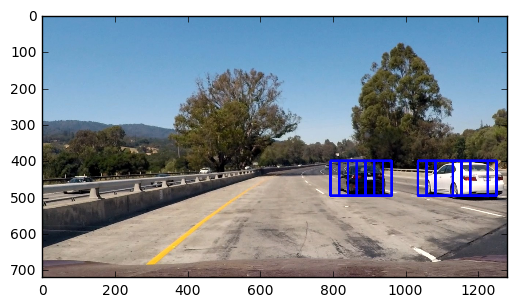

In [147]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale):
    dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    local_box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                topLeft = (xbox_left, ytop_draw+ystart)
                bottomRight = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                local_box_list.append((topLeft, bottomRight))
                
    return local_box_list

image = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 520
scale = 1.5
box_scale1 = find_cars(image, ystart, ystop, scale)

ystart = 480
ystop = 580
scale = 3
box_scale2 = find_cars(image, ystart, ystop, scale)

box_list = box_scale1 + box_scale2

out_img = draw_boxes(img, box_list)

plt.imshow(out_img)

### Pipeline (single images)

The pipeline will be organsied as follow: 
`process_image` is the overall pipeline function that will be used process the video.

Please note, the below cell have dependency on the 6 sections which contain the implementation detail of the functions.

In [132]:
# Define a class to receive the characteristics of each line detection
class CachedBox():
    def __init__(self): 
        # all the detected boxes
        self.allBoxes = [] 
        # last n boxes 
        self.heatMapBox = []
    
    def storeBoxes(self, newBoxes):
        self.allBoxes.append(newBoxes)
        self.heatMapBox = np.concatenate(self.allBoxes[-5:])

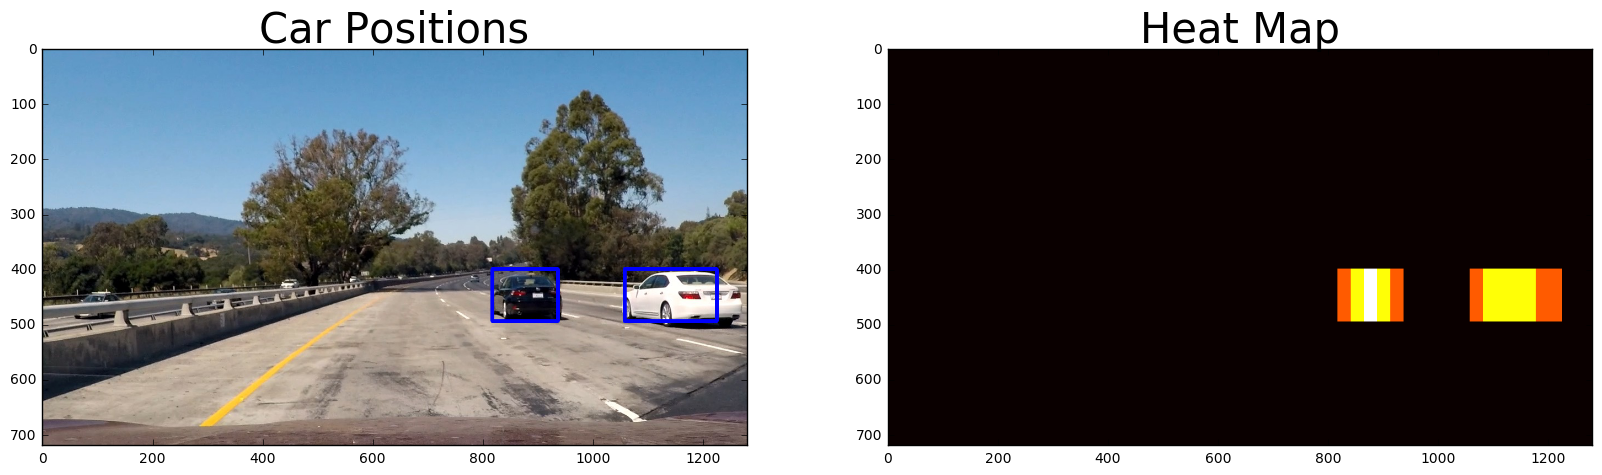

In [143]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def labeled_boxes(image, box_list):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return  heatmap, draw_img

heatmap, draw_img = labeled_boxes(image, box_list)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=30)
ax2.imshow(heatmap, cmap = 'hot')
ax2.set_title('Heat Map', fontsize=30)

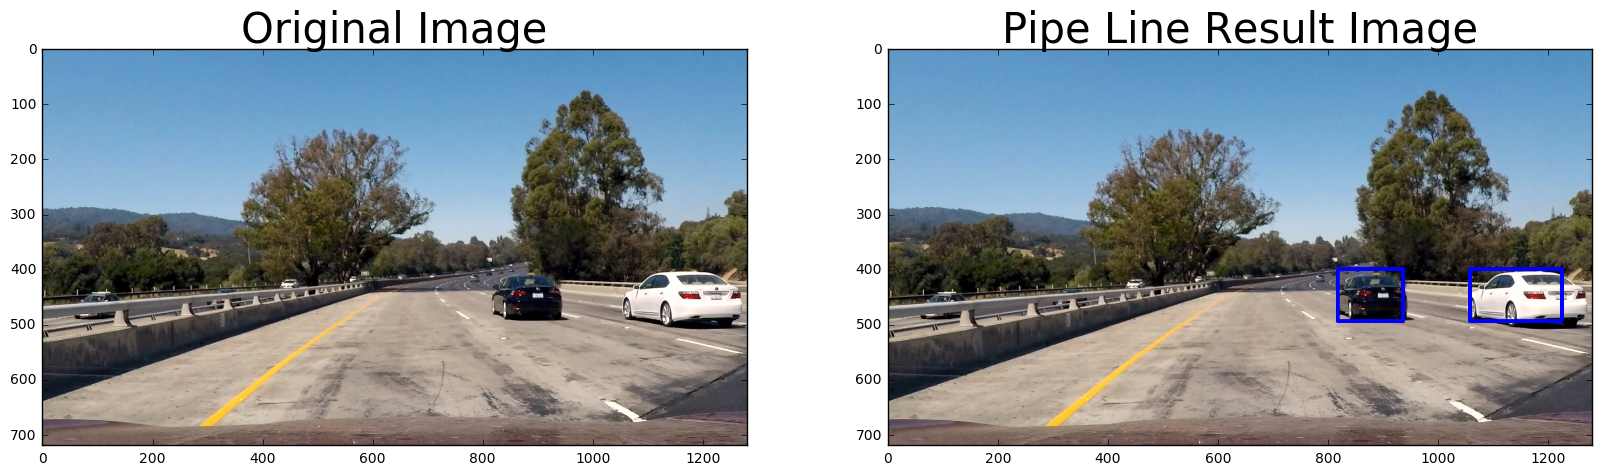

In [138]:
def prepare_image(image):
    # Find cars in the image
    
    ystart = 400
    ystop = 520
    scale = 1.5
    box_scale1 = find_cars(image, ystart, ystop, scale)

    ystart = 480
    ystop = 580
    scale = 3
    box_scale2 = find_cars(image, ystart, ystop, scale)

    new_box_list = box_scale1 + box_scale2
    
    # Store detection if needed
    if len(new_box_list) > 0:
        cachedBox.storeBoxes(new_box_list)
    
    # Prepare for headmap
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Load previous stored box for heat map
    heatMapBox = cachedBox.heatMapBox
    
    # Add heat to each box in box list
    heat = add_heat(heat,heatMapBox)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    outImg = draw_labeled_bboxes(np.copy(image), labels)
    
    return outImg

cachedBox = CachedBox()
processedImage = prepare_image(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(processedImage)
ax2.set_title('Pipe Line Result Image', fontsize=30)

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

In [140]:
pipe_line_output = "pipeLineOutput.mp4"
clip1 = VideoFileClip("project_video.mp4")
cachedBox = CachedBox()
pipe_line_output_clip = clip1.fl_image(prepare_image)
%time pipe_line_output_clip.write_videofile(pipe_line_output, audio=False)



[MoviePy] >>>> Building video pipeLineOutput.mp4
[MoviePy] Writing video pipeLineOutput.mp4


100%|█████████▉| 1260/1261 [02:37<00:00,  7.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: pipeLineOutput.mp4 

CPU times: user 10min 8s, sys: 27 s, total: 10min 35s
Wall time: 2min 37s
